# IMPORT LIBRARIES

In [3]:
%%capture
!pip install -q peft transformers datasets evaluate seqeval pymorphy2  datasets torch

In [4]:
%%capture
!pip install googletrans==4.0.0-rc1

In [5]:
%%capture
!pip install optuna scikit-learn matplotlib

In [6]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import KFold
import numpy as np
import torch
from googletrans import Translator
import random

In [7]:
%%capture
!pip install ipython-autotime

In [8]:
%load_ext autotime

time: 103 µs (started: 2024-06-20 20:30:18 +00:00)


## DATASET UPLOAD

In [9]:
from huggingface_hub import hf_hub_download

time: 4.45 ms (started: 2024-06-20 20:30:18 +00:00)


In [173]:
df = pd.read_excel('/kaggle/input/sentiment-dataset/sentiment_full.xlsx')

time: 209 ms (started: 2024-06-20 22:13:27 +00:00)


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Тип отношений  584 non-null    object
 1   Коды МСТК      584 non-null    object
 2   Страны         584 non-null    object
 3   Событие        584 non-null    object
 4   Источник       584 non-null    object
 5   Дата           584 non-null    object
 6   Тональность    584 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 32.1+ KB
time: 19.4 ms (started: 2024-06-20 22:13:48 +00:00)


In [11]:
# Dictionary mapping Russian column names to English column names
column_rename_dict = {
    'Тип отношений': 'Relationship Type',
    'Коды МСТК': 'MSTK Codes',
    'Страны': 'Countries',
    'Событие': 'text',
    'Источник': 'Source',
    'Дата': 'Date',
    'Тональность': 'sentiment'
}

df.rename(columns=column_rename_dict, inplace=True)

time: 5.71 ms (started: 2024-06-20 20:30:19 +00:00)


In [12]:
df.head()

,Relationship Type,MSTK Codes,Countries,text,Source,Date,sentiment
0,Внешняя торговля; Санкции,75 - Канцелярские машины и оборудование для ав...,"Венесуэла, Китай, Россия, США",США в очередной раз ужесточили правила экспорт...,https://www.rbc.ru/economics/30/06/2020/5ef9e4...,2020-06-30,-1
1,Санкции; Внешняя торговля,56 - Удобрения (кроме включенных в группу 272)...,"Бразилия, Россия","Санкции, введенные против России, такие как ис...",https://www1.folha.uol.com.br/internacional/en...,2022-03-02,-1
2,Санкции; Внешняя торговля,56 - Удобрения (кроме включенных в группу 272),"Бразилия, Россия, Разные Страны Африки, Разные...",Посол Бразилии в Организации Объединенных Наци...,https://www1.folha.uol.com.br/internacional/en...,2022-03-07,-1
3,Санкции,"93 - Специальные операции и товары, не классиф...","Россия, Индонезия, Таиланд",Беспрецедентные санкции против российских банк...,https://www.thejakartapost.com/paper/2022/03/1...,2022-03-11,-1
4,Внешняя торговля; Санкции,"33 - Нефть, нефтепродукты и аналогичные материалы","Индонезия, Россия, Разные Страны Европы и Севе...",Государственная энергетическая компания Индоне...,https://jakartaglobe.id/business/too-cheap-to-...,2022-03-29,1


time: 15.5 ms (started: 2024-06-20 20:30:19 +00:00)


In [13]:
data = df.copy()

time: 459 µs (started: 2024-06-20 20:30:19 +00:00)


In [14]:
sentiment_mapping = {0: 'neutral', -1: 'negative', 1: 'positive'}

data['sentiment'] = data['sentiment'].replace(sentiment_mapping)

data.head()

,Relationship Type,MSTK Codes,Countries,text,Source,Date,sentiment
0,Внешняя торговля; Санкции,75 - Канцелярские машины и оборудование для ав...,"Венесуэла, Китай, Россия, США",США в очередной раз ужесточили правила экспорт...,https://www.rbc.ru/economics/30/06/2020/5ef9e4...,2020-06-30,negative
1,Санкции; Внешняя торговля,56 - Удобрения (кроме включенных в группу 272)...,"Бразилия, Россия","Санкции, введенные против России, такие как ис...",https://www1.folha.uol.com.br/internacional/en...,2022-03-02,negative
2,Санкции; Внешняя торговля,56 - Удобрения (кроме включенных в группу 272),"Бразилия, Россия, Разные Страны Африки, Разные...",Посол Бразилии в Организации Объединенных Наци...,https://www1.folha.uol.com.br/internacional/en...,2022-03-07,negative
3,Санкции,"93 - Специальные операции и товары, не классиф...","Россия, Индонезия, Таиланд",Беспрецедентные санкции против российских банк...,https://www.thejakartapost.com/paper/2022/03/1...,2022-03-11,negative
4,Внешняя торговля; Санкции,"33 - Нефть, нефтепродукты и аналогичные материалы","Индонезия, Россия, Разные Страны Европы и Севе...",Государственная энергетическая компания Индоне...,https://jakartaglobe.id/business/too-cheap-to-...,2022-03-29,positive


time: 13 ms (started: 2024-06-20 20:30:19 +00:00)


In [15]:
data = data[['text', 'sentiment']]

time: 4.54 ms (started: 2024-06-20 20:30:19 +00:00)


In [16]:
data.head()

,text,sentiment
0,США в очередной раз ужесточили правила экспорт...,negative
1,"Санкции, введенные против России, такие как ис...",negative
2,Посол Бразилии в Организации Объединенных Наци...,negative
3,Беспрецедентные санкции против российских банк...,negative
4,Государственная энергетическая компания Индоне...,positive


time: 9.3 ms (started: 2024-06-20 20:30:19 +00:00)


### Shape of the dataset

In [17]:
print(f"Shape of texts (rows, cols)=> {data.shape}")

Shape of texts (rows, cols)=> (584, 2)
time: 3.6 ms (started: 2024-06-20 20:30:19 +00:00)


### Check duplicates

In [18]:
data.describe(include='all')

,text,sentiment
count,584,584
unique,583,3
top,Бразильские предприятия по производству вакцин...,positive
freq,2,219


time: 18.3 ms (started: 2024-06-20 20:30:19 +00:00)


In [19]:
data.text.duplicated(keep="first").value_counts()

text
False    583
True       1
Name: count, dtype: int64

time: 7.97 ms (started: 2024-06-20 20:30:19 +00:00)


In [20]:
data = data.drop_duplicates(subset="text", keep="first").reset_index(drop=True)

time: 3.86 ms (started: 2024-06-20 20:30:19 +00:00)


In [21]:
data.describe(include='all')

,text,sentiment
count,583,583
unique,583,3
top,Индия отказывается от долларов в торговле нефт...,positive
freq,1,218


time: 10.5 ms (started: 2024-06-20 20:30:24 +00:00)


### Number of texts per Sentiments

In [22]:
data.sentiment.value_counts()

sentiment
positive    218
neutral     185
negative    180
Name: count, dtype: int64

time: 4.46 ms (started: 2024-06-20 20:30:25 +00:00)


In [23]:
import matplotlib.pyplot as plt

time: 353 µs (started: 2024-06-20 20:30:25 +00:00)


In [24]:
import warnings
warnings.filterwarnings('ignore')

time: 485 µs (started: 2024-06-20 20:30:26 +00:00)


In [25]:
import plotly.express as px


fig = px.bar(data, x=data.sentiment.value_counts().index, y=data.sentiment.value_counts().values, 
             labels={'x':'Sentiments', 'y':'Number of Texts'},
             title='Sentiment Distribution',
             color=data.sentiment.value_counts().index,
             color_discrete_sequence=['purple', 'orange', 'cyan'])

fig.show();

time: 2.06 s (started: 2024-06-20 20:30:26 +00:00)


The dataset is **balanced (more or less)**: the number of samples are almost evenly distrubuted over the sentiments.
---

The dataset is too small and we need to augment it.

## Data augmentation using Translator

In [26]:
translator = Translator()

def back_translate(text, src='ru', mid='en'):
    """Translate text to a mid language and back to the source language."""
    translated = translator.translate(text, src=src, dest=mid).text
    back_translated = translator.translate(translated, src=mid, dest=src).text
    return back_translated

time: 16.7 ms (started: 2024-06-20 20:30:35 +00:00)


In [27]:
data_df = data.copy()

time: 819 µs (started: 2024-06-20 20:30:37 +00:00)


In [28]:
texts = data_df['text'].tolist()
labels = data_df['sentiment'].map({'positive': 0, 'neutral': 1, 'negative': 2}).tolist()

time: 1.7 ms (started: 2024-06-20 20:30:38 +00:00)


In [29]:
mid_languages = ['fr', 'es', 'de', 'tr', 'pt', 'nl', 'it', 'la', 'la', 'no', 'fi', 'el', 'da', 'bn', 'tl', 'ht', 'lo', 'mn', 'tg', 'yo']

augmented_texts = []
augmented_labels = []

for _ in range(16):
    for text, label in zip(texts, labels):
        mid_language = random.choice(mid_languages)
        try:
            aug_text = back_translate(text, src='ru', mid=mid_language)
            augmented_texts.append(aug_text)
            augmented_labels.append(label)
        except Exception as e:
            print(f"Error in translation: {e}")
            continue

combined_texts = texts + augmented_texts
combined_labels = labels + augmented_labels

time: 32.4 s (started: 2024-06-20 20:30:40 +00:00)



KeyboardInterrupt



In [ ]:
data_augmented = pd.DataFrame({'text': combined_texts, 'label': combined_labels})

In [ ]:
data_augmented.to_excel('/kaggle/input/augmented-datset-16-x/augmented_full_sentiment_16_x.xlsx')

## Import new Dataset

In [39]:
data = data.drop('Unnamed: 0', axis=True)

time: 1.49 ms (started: 2024-06-20 20:31:31 +00:00)


In [30]:
data = pd.read_excel('/kaggle/input/augmented-datset-16-x/augmented_full_sentiment_16_x.xlsx')

time: 1.29 s (started: 2024-06-20 20:31:18 +00:00)


In [41]:
data.tail()

,text,label,sentiment
6930,Польша запустила запрет Европейского Союза на ...,1,neutral
6931,В 2022 году Китай тщательно контролировал санк...,2,negative
6932,Немецкий производитель нефти и газа Wintershal...,1,neutral
6933,Российский энергетический гигант Роснефт объяв...,0,positive
6934,Индия отказывается от долларов на торговлю неф...,0,positive


time: 7.48 ms (started: 2024-06-20 20:31:53 +00:00)


In [42]:
data.label.unique()

array([2, 0, 1])

time: 3.32 ms (started: 2024-06-20 20:31:54 +00:00)


In [43]:
sentiment_mapping = {0: 'positive', 1: 'neutral', 2: 'negative'}

data['sentiment'] = data['label'].replace(sentiment_mapping)

data.head()

,text,label,sentiment
0,США в очередной раз ужесточили правила экспорт...,2,negative
1,"Санкции, введенные против России, такие как ис...",2,negative
2,Посол Бразилии в Организации Объединенных Наци...,2,negative
3,Беспрецедентные санкции против российских банк...,2,negative
4,Государственная энергетическая компания Индоне...,0,positive


time: 9.64 ms (started: 2024-06-20 20:31:55 +00:00)


### Recheck duplicates

In [44]:
data.describe(include='all')

,text,label,sentiment
count,6935,6935.000000,6935
unique,6935,NaN,3
top,Индия отказывается от долларов на торговлю неф...,NaN,positive
freq,1,NaN,2594
mean,NaN,0.939005,NaN
std,NaN,0.826724,NaN
min,NaN,0.000000,NaN
25%,NaN,0.000000,NaN
50%,NaN,1.000000,NaN
75%,NaN,2.000000,NaN


time: 22.8 ms (started: 2024-06-20 20:31:56 +00:00)


In [45]:
empty_cells = data.isnull().sum().sum()
print("Number of empty cells:", empty_cells)

Number of empty cells: 0
time: 3.25 ms (started: 2024-06-20 20:31:57 +00:00)


In [46]:
nan_count = data.isna().sum().sum()
print("Number of NaN values:", nan_count)

Number of NaN values: 0
time: 3.52 ms (started: 2024-06-20 20:31:57 +00:00)


In [47]:
data.text.duplicated(keep="first").value_counts()

text
False    6935
Name: count, dtype: int64

time: 5.81 ms (started: 2024-06-20 20:31:58 +00:00)


In [48]:
data = data.drop_duplicates(subset="text", keep="first").reset_index(drop=True)

time: 4.14 ms (started: 2024-06-20 20:31:59 +00:00)


In [49]:
data.tail()

,text,label,sentiment
6930,Польша запустила запрет Европейского Союза на ...,1,neutral
6931,В 2022 году Китай тщательно контролировал санк...,2,negative
6932,Немецкий производитель нефти и газа Wintershal...,1,neutral
6933,Российский энергетический гигант Роснефт объяв...,0,positive
6934,Индия отказывается от долларов на торговлю неф...,0,positive


time: 6.8 ms (started: 2024-06-20 20:32:02 +00:00)


## **Analyze News (Text)**

### Calculate the number of words in each reviews

In [50]:
%%capture
!pip install nltk pymorphy2

time: 13.2 s (started: 2024-06-20 20:32:05 +00:00)


In [51]:
import nltk
from pymorphy2 import MorphAnalyzer
import pymorphy2
from nltk.tokenize import word_tokenize

time: 535 ms (started: 2024-06-20 20:32:41 +00:00)


In [52]:
data['words'] = data['text'].apply(lambda x: len(word_tokenize(x)))

time: 3.82 s (started: 2024-06-20 20:32:43 +00:00)


In [53]:
data['words'].describe()

count    6935.000000
mean       40.966979
std        27.172317
min         2.000000
25%        23.000000
50%        33.000000
75%        51.000000
max       281.000000
Name: words, dtype: float64

time: 7.76 ms (started: 2024-06-20 20:32:46 +00:00)


### **Review Length in terms of Number of Words per Topic**

In [54]:
data = data[data['words'] >= 8]

time: 2.73 ms (started: 2024-06-20 20:33:04 +00:00)


In [55]:
data.groupby(['sentiment'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,2165.0,41.300693,28.425920,8.0,22.0,32.0,52.0,231.0
neutral,2163.0,39.233010,25.872156,8.0,24.0,32.0,46.0,281.0
positive,2577.0,42.546372,26.975063,8.0,23.0,35.0,54.0,279.0


time: 23.9 ms (started: 2024-06-20 20:33:08 +00:00)


In [56]:
fig = px.bar(data, x=data.sentiment.value_counts().index, y=data.sentiment.value_counts().values, 
             labels={'x':'Sentiments', 'y':'Number of Texts'},
             title='Sentiment Distribution',
             color=data.sentiment.value_counts().index,
             color_discrete_sequence=['purple', 'orange', 'cyan'])

fig.show()

time: 78.4 ms (started: 2024-06-20 20:33:09 +00:00)


In [57]:
data.tail()

,text,label,sentiment,words
6930,Польша запустила запрет Европейского Союза на ...,1,neutral,31
6931,В 2022 году Китай тщательно контролировал санк...,2,negative,33
6932,Немецкий производитель нефти и газа Wintershal...,1,neutral,27
6933,Российский энергетический гигант Роснефт объяв...,0,positive,32
6934,Индия отказывается от долларов на торговлю неф...,0,positive,13


time: 7.47 ms (started: 2024-06-20 20:33:18 +00:00)


In [58]:
data.text.describe()

count                                                  6905
unique                                                 6905
top       Индия отказывается от долларов на торговлю неф...
freq                                                      1
Name: text, dtype: object

time: 10.6 ms (started: 2024-06-20 20:33:19 +00:00)


## **Analyze the Vocabulary**

### Count the distinct words

In [59]:
vocab = {word.lower() for sentence in [x.split() for x in data['text'].tolist()] for word in sentence}
print("Number of distinct words in raw data:", len(vocab))

Number of distinct words in raw data: 29647
time: 124 ms (started: 2024-06-20 20:33:24 +00:00)


### Count the frequency of words in the raw dataset

In [60]:
vocab_size = len(vocab)
word_freq = (
    data.text.str.split(expand=True)
    .stack()
    .value_counts()
    .reset_index(name='freq')
    .rename(columns={'index': 'word'})
)

time: 310 ms (started: 2024-06-20 20:33:26 +00:00)


In [61]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time: 89.4 ms (started: 2024-06-20 20:33:28 +00:00)


In [62]:
%%capture
!pip install nltk==3.8.1 stop_words==2018.7.23

time: 14.3 s (started: 2024-06-20 20:33:30 +00:00)


In [63]:
from stop_words import get_stop_words

time: 9.83 ms (started: 2024-06-20 20:33:50 +00:00)


In [64]:
russian_stop_words = set(stopwords.words('russian'))  
russian_stop_words.update(get_stop_words('russian'))

time: 4.86 ms (started: 2024-06-20 20:33:52 +00:00)


In [65]:
russian_stop_words = set(stopwords.words('russian'))  
russian_stop_words.update(get_stop_words('russian'))

def check_stopwords(text):
    words = text.lower().split()
    stopwords_found = [word for word in words if word in russian_stop_words]
    return stopwords_found

data['stopwords'] = data['text'].apply(check_stopwords)

time: 86.1 ms (started: 2024-06-20 20:33:58 +00:00)


In [66]:
dataюефг

,text,label,sentiment,words,stopwords
0,США в очередной раз ужесточили правила экспорт...,2,negative,136,"[в, раз, в, в, в, два, и, которые, еще, больше..."
1,"Санкции, введенные против России, такие как ис...",2,negative,92,"[против, такие, как, её, из, и, могут, из, это..."
2,Посол Бразилии в Организации Объединенных Наци...,2,negative,82,"[в, в, которой, на, однако, в, своей, он, кото..."
3,Беспрецедентные санкции против российских банк...,2,negative,81,"[против, на, ее, за, на, и, в, которые, были, ..."
4,Государственная энергетическая компания Индоне...,0,positive,41,"[для, у, на, против, этой, при, в, в, по]"
...,...,...,...,...,...
6930,Польша запустила запрет Европейского Союза на ...,1,neutral,31,"[на, к, всех, в, против, в, за, по, с]"
6931,В 2022 году Китай тщательно контролировал санк...,2,negative,33,"[в, году, против, в, то, время, как, что, таки..."
6932,Немецкий производитель нефти и газа Wintershal...,1,neutral,27,"[и, который, только, что, с, против, или, других]"
6933,Российский энергетический гигант Роснефт объяв...,0,positive,32,"[о, по, в, в, по, к, из, в]"


time: 17.1 ms (started: 2024-06-20 20:33:59 +00:00)


### **Column with words without stop words**

In [67]:
def remove_stopwords(text):
    words = text.lower().split()
    cleaned_words = [word for word in words if word not in russian_stop_words]
    return ' '.join(cleaned_words)

data['words_clean'] = data['text'].apply(remove_stopwords)

time: 98.7 ms (started: 2024-06-20 20:34:10 +00:00)


In [68]:
data.head()

,text,label,sentiment,words,stopwords,words_clean
0,США в очередной раз ужесточили правила экспорт...,2,negative,136,"[в, раз, в, в, в, два, и, которые, еще, больше...",сша очередной ужесточили правила экспортного к...
1,"Санкции, введенные против России, такие как ис...",2,negative,92,"[против, такие, как, её, из, и, могут, из, это...","санкции, введенные россии, исключение банков м..."
2,Посол Бразилии в Организации Объединенных Наци...,2,negative,82,"[в, в, которой, на, однако, в, своей, он, кото...",посол бразилии организации объединенных наций ...
3,Беспрецедентные санкции против российских банк...,2,negative,81,"[против, на, ее, за, на, и, в, которые, были, ...",беспрецедентные санкции российских банков нега...
4,Государственная энергетическая компания Индоне...,0,positive,41,"[для, у, на, против, этой, при, в, в, по]",государственная энергетическая компания индоне...


time: 10.8 ms (started: 2024-06-20 20:34:11 +00:00)


In [69]:
data['words_clean_count'] = data['words_clean'].apply(lambda x: len(word_tokenize(x)))

time: 3.41 s (started: 2024-06-20 20:34:23 +00:00)


In [70]:
data.head()

,text,label,sentiment,words,stopwords,words_clean,words_clean_count
0,США в очередной раз ужесточили правила экспорт...,2,negative,136,"[в, раз, в, в, в, два, и, которые, еще, больше...",сша очередной ужесточили правила экспортного к...,105
1,"Санкции, введенные против России, такие как ис...",2,negative,92,"[против, такие, как, её, из, и, могут, из, это...","санкции, введенные россии, исключение банков м...",63
2,Посол Бразилии в Организации Объединенных Наци...,2,negative,82,"[в, в, которой, на, однако, в, своей, он, кото...",посол бразилии организации объединенных наций ...,62
3,Беспрецедентные санкции против российских банк...,2,negative,81,"[против, на, ее, за, на, и, в, которые, были, ...",беспрецедентные санкции российских банков нега...,59
4,Государственная энергетическая компания Индоне...,0,positive,41,"[для, у, на, против, этой, при, в, в, по]",государственная энергетическая компания индоне...,32


time: 14.3 ms (started: 2024-06-20 20:34:28 +00:00)


In [71]:
data.groupby(['sentiment'])['words_clean_count'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,2165.0,31.829099,21.920403,6.0,17.0,25.0,40.0,193.0
neutral,2163.0,30.263985,19.386023,6.0,19.0,25.0,36.0,197.0
positive,2577.0,32.450912,20.534266,5.0,18.0,27.0,41.0,204.0


time: 21.7 ms (started: 2024-06-20 20:34:33 +00:00)


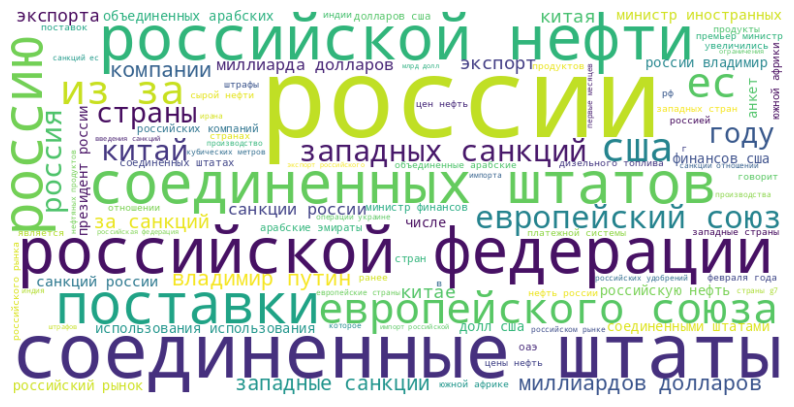

time: 2.49 s (started: 2024-06-20 20:34:52 +00:00)


In [73]:
from wordcloud import WordCloud

df = data.copy()

all_text = ' '.join(df['words_clean'])

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **PREPARE THE DATASET**

In [74]:
texts = data['words_clean'].tolist()
labels = data['label'].tolist()

time: 1.55 ms (started: 2024-06-20 20:35:07 +00:00)


For inferrence

In [75]:
def translate_to_russian(text):
  translator = Translator()
  result = translator.translate(text, dest='ru')
  return result.text

time: 495 µs (started: 2024-06-20 20:35:14 +00:00)


In [76]:
df = pd.DataFrame({'text': texts, 'label': labels})
df.head()

,text,label
0,сша очередной ужесточили правила экспортного к...,2
1,"санкции, введенные россии, исключение банков м...",2
2,посол бразилии организации объединенных наций ...,2
3,беспрецедентные санкции российских банков нега...,2
4,государственная энергетическая компания индоне...,0


time: 12 ms (started: 2024-06-20 20:35:19 +00:00)


## **Create Dataset**

In [78]:
dataset = Dataset.from_pandas(df)

time: 20.6 ms (started: 2024-06-20 20:35:59 +00:00)


In [79]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 6905
})

time: 2.99 ms (started: 2024-06-20 20:36:00 +00:00)


## Split the dataset

In [81]:
train_val_dataset, test_dataset = dataset.train_test_split(test_size=0.2, seed=42).values()
train_dataset, val_dataset = train_val_dataset.train_test_split(test_size=0.1, seed=42).values()

time: 15.9 ms (started: 2024-06-20 20:36:36 +00:00)


In [82]:
test_dataset, train_dataset, val_dataset

(Dataset({
     features: ['text', 'label'],
     num_rows: 1381
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 4971
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 553
 }))

time: 3.39 ms (started: 2024-06-20 20:36:40 +00:00)


### Tokenize the Data

In [85]:
from transformers import DistilBertTokenizer

model_name = "distilbert-base-multilingual-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], max_length=512, truncation=True, padding="max_length")

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


Map:   0%|          | 0/4971 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

Map:   0%|          | 0/1381 [00:00<?, ? examples/s]

time: 22.7 s (started: 2024-06-20 20:37:26 +00:00)


In [86]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['text', 'label', 'input_ids', 'attention_mask'],
     num_rows: 4971
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'attention_mask'],
     num_rows: 553
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'attention_mask'],
     num_rows: 1381
 }))

time: 3.27 ms (started: 2024-06-20 20:37:57 +00:00)


In [87]:
%%capture
!pip install peft

time: 14 s (started: 2024-06-20 20:38:03 +00:00)


In [88]:
%%capture
!pip install optuna

time: 13.6 s (started: 2024-06-20 20:38:17 +00:00)


# **Model Training**

In [89]:
import torch
from transformers import Trainer, TrainingArguments, DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.nn import BCEWithLogitsLoss
from datasets import load_metric

2024-06-20 20:38:34.355343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 20:38:34.355460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 20:38:34.498285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


time: 13.3 s (started: 2024-06-20 20:38:31 +00:00)


wb: 03bef68b86443c0d34116c69d31990189a72ccfd

In [90]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)
print(model)

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## **Define compute_metrics function for evaluation**

In [91]:
%%capture
!pip install evaluate

time: 2.83 s (started: 2024-06-20 20:38:59 +00:00)


In [92]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted', zero_division=1)
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

time: 859 µs (started: 2024-06-20 20:39:05 +00:00)


## **Define training arguments**

In [92]:
%%capture
!pip install peft

time: 12.3 s (started: 2024-06-20 19:58:48 +00:00)


In [93]:
from peft import LoraConfig, get_peft_model

time: 938 ms (started: 2024-06-20 20:39:21 +00:00)


In [110]:
params = {'learning_rate': 4.993596574084884e-05, 'batch_size': 8, 'num_train_epochs': 10, 'lora_alpha': 32, 'r': 8}

time: 1.97 ms (started: 2024-06-20 20:46:41 +00:00)


In [111]:
config = LoraConfig(
    r=params['r'],
    lora_alpha=params['lora_alpha'],
    target_modules=["attention.q_lin", "attention.k_lin", "attention.v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

time: 1.18 ms (started: 2024-06-20 20:46:42 +00:00)


In [112]:
config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=8, target_modules={'attention.v_lin', 'attention.k_lin', 'attention.q_lin'}, lora_alpha=32, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

time: 4.41 ms (started: 2024-06-20 20:46:42 +00:00)


In [113]:
model = get_peft_model(model, config)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=params['learning_rate'],
    per_device_train_batch_size=params['batch_size'],
    per_device_eval_batch_size=params['batch_size'],
    num_train_epochs=params['num_train_epochs'],
    weight_decay=0.01,
    logging_dir='./logs',
)

time: 58.4 ms (started: 2024-06-20 20:46:43 +00:00)


## **Initialize trainer**

In [114]:
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

time: 3.73 ms (started: 2024-06-20 20:46:45 +00:00)


In [115]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

time: 11.9 ms (started: 2024-06-20 20:46:45 +00:00)


## **Train the model and Evaluate**

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

time: 1.78 ms (started: 2024-06-20 20:46:47 +00:00)


In [117]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.021800,0.881649,0.573237,0.573193,0.581216,0.573237
2,0.865400,0.761000,0.660036,0.653854,0.661971,0.660036
3,0.753400,0.690441,0.696203,0.691167,0.707931,0.696203
4,0.659300,0.640569,0.734177,0.729029,0.745441,0.734177
5,0.527800,0.555681,0.773960,0.773242,0.776295,0.773960
6,0.493900,0.542025,0.777577,0.776376,0.781946,0.777577
7,0.458500,0.525808,0.792043,0.789921,0.799897,0.792043
8,0.418100,0.501257,0.802893,0.802343,0.804635,0.802893
9,0.380400,0.492222,0.806510,0.805298,0.810920,0.806510
10,0.364200,0.482329,0.806510,0.805615,0.808531,0.806510


TrainOutput(global_step=6220, training_loss=0.5725782302414872, metrics={'train_runtime': 1238.6841, 'train_samples_per_second': 40.131, 'train_steps_per_second': 5.021, 'total_flos': 6709389719040000.0, 'train_loss': 0.5725782302414872, 'epoch': 10.0})

time: 20min 39s (started: 2024-06-20 20:46:47 +00:00)


In [119]:
results = trainer.evaluate(eval_dataset=test_dataset)
results

{'eval_loss': 0.4465404450893402,
 'eval_accuracy': 0.8225923244026068,
 'eval_f1': 0.82199317411813,
 'eval_precision': 0.8231166598026648,
 'eval_recall': 0.8225923244026068,
 'eval_runtime': 13.5521,
 'eval_samples_per_second': 101.903,
 'eval_steps_per_second': 12.766,
 'epoch': 10.0}

time: 13.6 s (started: 2024-06-20 21:08:09 +00:00)


In [184]:
%%capture
!pip install torch-summary ignite

time: 14.1 s (started: 2024-06-20 22:43:22 +00:00)


In [185]:
from torchsummary import summary
model_stats = summary(model)
summary_str = str(model_stats)

# Print the summary
print(summary_str)

Layer (type:depth-idx)                                       Param #
├─LoraModel: 1-1                                             --
|    └─PeftModelForSequenceClassification: 2-1               --
|    |    └─LoraModel: 3-1                                   (136,141,062)
Total params: 136,141,062
Trainable params: 0
Non-trainable params: 136,141,062
Layer (type:depth-idx)                                       Param #
├─LoraModel: 1-1                                             --
|    └─PeftModelForSequenceClassification: 2-1               --
|    |    └─LoraModel: 3-1                                   (136,141,062)
Total params: 136,141,062
Trainable params: 0
Non-trainable params: 136,141,062
time: 34.7 ms (started: 2024-06-20 22:43:51 +00:00)


In [178]:
?model

time: 8.57 ms (started: 2024-06-20 22:39:30 +00:00)


Signature:   model(*args, **kwargs)
Type:        PeftModelForSequenceClassification
String form:
PeftModelForSequenceClassification(
           (base_model): LoraModel(
           (model): PeftModelForSequenceC <...>  (dropout): Dropout(p=0.2, inplace=False)
           )
           )
           )
           )
           )
           )
           )
File:        /opt/conda/lib/python3.10/site-packages/peft/peft_model.py
Docstring:  
Peft model for sequence classification tasks.

Args:
    model ([`~transformers.PreTrainedModel`]): Base transformer model.
    peft_config ([`PeftConfig`]): Peft config.

**Attributes**:
    - **config** ([`~transformers.PretrainedConfig`]) -- The configuration object of the base model.
    - **cls_layer_name** (`str`) -- The name of the classification layer.

Example:

    ```py
    >>> from transformers import AutoModelForSequenceClassification
    >>> from peft import PeftModelForSequenceClassification, get_peft_config

    >>> config = {
    ...     "pef

In [122]:
results_metrics = {
    'eval_accuracy': results['eval_accuracy'] * 100,
    'eval_f1': results['eval_f1'] * 100,
    'eval_precision': results['eval_precision'] * 100,
    'eval_recall': results['eval_recall'] * 100
}

time: 1.47 ms (started: 2024-06-20 21:13:02 +00:00)


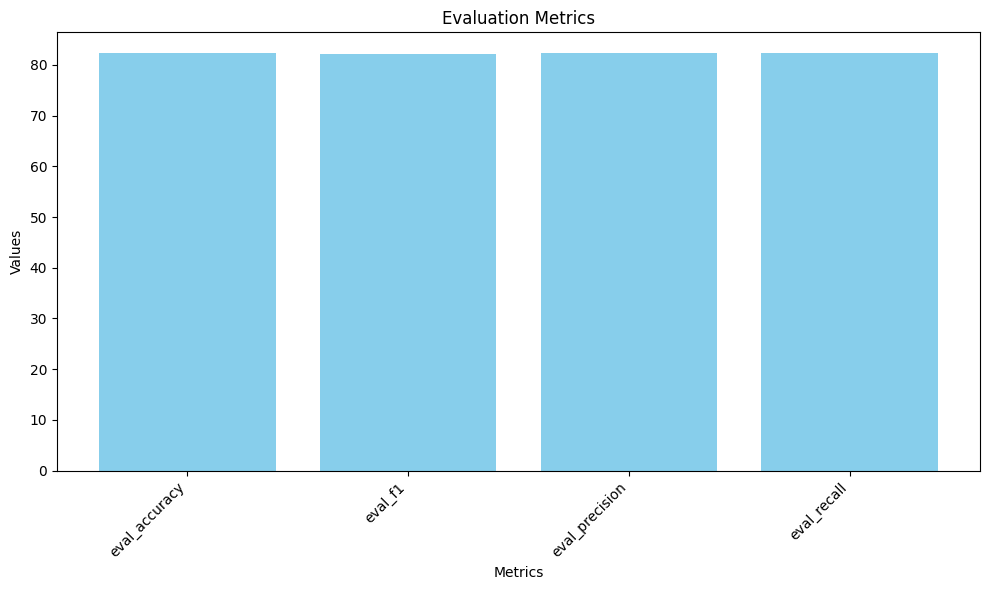

time: 261 ms (started: 2024-06-20 21:13:05 +00:00)


In [123]:
metric_names = list(results_metrics.keys())
metric_values = list(results_metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Results analysis

In [125]:
test_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1381
})

time: 3.62 ms (started: 2024-06-20 21:16:28 +00:00)


In [126]:
eval_results = trainer.evaluate(eval_dataset=test_dataset)

time: 13.6 s (started: 2024-06-20 21:16:41 +00:00)


# **Define an inference function**


In [189]:
def predict(texts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.sigmoid(logits) > 0.5
    return predictions

time: 2.89 ms (started: 2024-06-20 22:54:03 +00:00)


In [147]:
trainer.save_model('/multilabel_lora_distilbert_classifier')

time: 1.44 s (started: 2024-06-20 21:30:39 +00:00)


In [155]:
model.save_pretrained("/multilabel_lora_distilbert_classifier_tuned")

time: 23.9 ms (started: 2024-06-20 21:39:34 +00:00)


In [157]:
trainer.model.save_pretrained("/multilabel_lora_distilbert_classifier_tuned")

time: 26.5 ms (started: 2024-06-20 21:41:35 +00:00)


In [162]:
trainer.push_to_hub("/multilabel_lora_distilbert_classifier")

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/545M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/boods/results/commit/50d2bc93756eeea0021b84eeed052c2b24369e0a', commit_message='/multilabel_lora_distilbert_classifier', commit_description='', oid='50d2bc93756eeea0021b84eeed052c2b24369e0a', pr_url=None, pr_revision=None, pr_num=None)

time: 19.9 s (started: 2024-06-20 21:49:12 +00:00)


In [191]:
load_model = DistilBertTokenizer.from_pretrained('boods/results')

time: 358 ms (started: 2024-06-20 22:54:50 +00:00)


In [192]:
load_model

DistilBertTokenizer(name_or_path='boods/results', vocab_size=119547, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

time: 4.66 ms (started: 2024-06-20 22:55:00 +00:00)


In [169]:
texts = ["Экс-глава итальянского правительства Сильвио Берлускони заявил, что Россия изолирована от Запада, но Запад изолирован от остальных государств мира, так как даже Турция не присоединилась к западным санкциям против Москвы.", "Ряд банков Казахстана и Вьетнама приостановили прием карт «Мир» на фоне предупреждения минфина США о готовности ввести санкции за поддержку использования платежной системы «Мир» за пределами России."]
predictions = predict(texts)
print(predictions)

AttributeError: 'DistilBertTokenizer' object has no attribute 'to'

time: 81.6 ms (started: 2024-06-20 21:56:48 +00:00)


In [245]:
test_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1381
})

time: 4.4 ms (started: 2024-06-16 08:27:52 +00:00)


In [130]:
def predict(texts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    
    probabilities = torch.sigmoid(logits)
    
    probabilities = probabilities.cpu().numpy()
    
    predictions = probabilities.argmax(axis=1)
    
    return probabilities, predictions

time: 1.7 ms (started: 2024-06-20 21:17:28 +00:00)


In [131]:
texts = [
    "Экс-глава итальянского правительства Сильвио Берлускони заявил, что Россия изолирована от Запада, но Запад изолирован от остальных государств мира, так как даже Турция не присоединилась к западным санкциям против Москвы.",
    "Ряд банков Казахстана и Вьетнама приостановили прием карт «Мир» на фоне предупреждения минфина США о готовности ввести санкции за поддержку использования платежной системы «Мир» за пределами России."
]

probabilities, predictions = predict(texts)

for i, text in enumerate(texts):
    print(f"Text: {text}")
    print(f"Probabilities: {probabilities[i]}")
    print(f"Predicted Label: {predictions[i]}\n")

Text: Экс-глава итальянского правительства Сильвио Берлускони заявил, что Россия изолирована от Запада, но Запад изолирован от остальных государств мира, так как даже Турция не присоединилась к западным санкциям против Москвы.
Probabilities: [0.1556126  0.98264414 0.04264545]
Predicted Label: 1

Text: Ряд банков Казахстана и Вьетнама приостановили прием карт «Мир» на фоне предупреждения минфина США о готовности ввести санкции за поддержку использования платежной системы «Мир» за пределами России.
Probabilities: [0.02219138 0.34123382 0.97385705]
Predicted Label: 2

time: 25.8 ms (started: 2024-06-20 21:17:32 +00:00)


In [132]:
df_to_predict = pd.read_excel('/kaggle/input/titles-ru-labelled/_____271123.xlsx')

time: 199 ms (started: 2024-06-20 21:17:59 +00:00)


In [133]:
df_to_predict = df_to_predict[['title', 'sentiment']]

time: 2.3 ms (started: 2024-06-20 21:18:00 +00:00)


In [134]:
df_to_predict

,title,sentiment
0,Экс-глава итальянского правительства Сильвио Б...,negative
1,Ряд банков Казахстана и Вьетнама приостановили...,negative
2,Россия после вступления в силу эмбарго Евросою...,positive
3,Пресс-секретарь президента Дмитрий Песков прок...,negative
4,В США призвали ввести санкции против закупок К...,negative
...,...,...
481,Минсельхоз предлагает не ограничивать список т...,negative
482,Суд Лондона обязал норвежскую судоходную компа...,negative
483,В условиях санкционного давления наблюдается р...,positive
484,Американский производитель одежды Gap не ушел ...,neutral


time: 10.4 ms (started: 2024-06-20 21:18:02 +00:00)


wb: f9b7f72ed50a5f671508f1f5e7a9d07629380467

In [136]:
df_to_predict['text'] = df_to_predict['title'].apply(remove_stopwords)

time: 17.2 ms (started: 2024-06-20 21:18:21 +00:00)


In [271]:
df_to_predict

,title,sentiment,text
0,Экс-глава итальянского правительства Сильвио Б...,negative,экс-глава итальянского правительства сильвио б...
1,Ряд банков Казахстана и Вьетнама приостановили...,negative,ряд банков казахстана вьетнама приостановили п...
2,Россия после вступления в силу эмбарго Евросою...,positive,россия вступления силу эмбарго евросоюза перен...
3,Пресс-секретарь президента Дмитрий Песков прок...,negative,пресс-секретарь президента дмитрий песков прок...
4,В США призвали ввести санкции против закупок К...,negative,сша призвали ввести санкции закупок китаем эне...
...,...,...,...
481,Минсельхоз предлагает не ограничивать список т...,negative,минсельхоз предлагает ограничивать список теру...
482,Суд Лондона обязал норвежскую судоходную компа...,negative,суд лондона обязал норвежскую судоходную компа...
483,В условиях санкционного давления наблюдается р...,positive,условиях санкционного давления наблюдается рос...
484,Американский производитель одежды Gap не ушел ...,neutral,американский производитель одежды gap ушел рос...


time: 10.5 ms (started: 2024-06-16 08:41:38 +00:00)


In [137]:
sentiment_mapping = {'positive': 0,'neutral': 1, 'negative': 2}

df_to_predict['true_labels'] = df_to_predict['sentiment'].replace(sentiment_mapping)

df_to_predict.head()

,title,sentiment,text,true_labels
0,Экс-глава итальянского правительства Сильвио Б...,negative,экс-глава итальянского правительства сильвио б...,2
1,Ряд банков Казахстана и Вьетнама приостановили...,negative,ряд банков казахстана вьетнама приостановили п...,2
2,Россия после вступления в силу эмбарго Евросою...,positive,россия вступления силу эмбарго евросоюза перен...,0
3,Пресс-секретарь президента Дмитрий Песков прок...,negative,пресс-секретарь президента дмитрий песков прок...,2
4,В США призвали ввести санкции против закупок К...,negative,сша призвали ввести санкции закупок китаем эне...,2


time: 13.2 ms (started: 2024-06-20 21:18:37 +00:00)


In [138]:
texts = df_to_predict['text'].tolist()
probabilities, predictions = predict(texts)

probabilities_df = pd.DataFrame(probabilities, columns=[f'probability_label_{i}' for i in range(probabilities.shape[1])])

df_to_predict = pd.concat([df_to_predict, probabilities_df], axis=1)
df_to_predict['prediction'] = predictions

df_to_predict.head()

,title,sentiment,text,true_labels,probability_label_0,probability_label_1,probability_label_2,prediction
0,Экс-глава итальянского правительства Сильвио Б...,negative,экс-глава итальянского правительства сильвио б...,2,0.363048,0.959983,0.041640,1
1,Ряд банков Казахстана и Вьетнама приостановили...,negative,ряд банков казахстана вьетнама приостановили п...,2,0.027372,0.341181,0.962322,2
2,Россия после вступления в силу эмбарго Евросою...,positive,россия вступления силу эмбарго евросоюза перен...,0,0.910292,0.202163,0.294348,0
3,Пресс-секретарь президента Дмитрий Песков прок...,negative,пресс-секретарь президента дмитрий песков прок...,2,0.037227,0.668595,0.882027,2
4,В США призвали ввести санкции против закупок К...,negative,сша призвали ввести санкции закупок китаем эне...,2,0.075185,0.048433,0.995060,2


time: 4.38 s (started: 2024-06-20 21:18:43 +00:00)


## CLASSFICATION REPORT

In [139]:
preds = trainer.predict(test_dataset)

time: 13.5 s (started: 2024-06-20 21:19:27 +00:00)


In [140]:
preds.label_ids

array([1, 0, 2, ..., 0, 0, 0])

time: 5.04 ms (started: 2024-06-20 21:19:42 +00:00)


In [141]:
predictions = np.argmax(preds.predictions, axis=1)
true_labels = preds.label_ids

time: 1.49 ms (started: 2024-06-20 21:19:45 +00:00)


In [142]:
conf_matrix = confusion_matrix(true_labels, predictions)

time: 3.84 ms (started: 2024-06-20 21:19:47 +00:00)


In [188]:
true_labels

0      2
1      2
2      0
3      2
4      2
      ..
481    2
482    2
483    0
484    1
485    1
Name: true_labels, Length: 486, dtype: int64

time: 6.05 ms (started: 2024-06-20 22:52:19 +00:00)


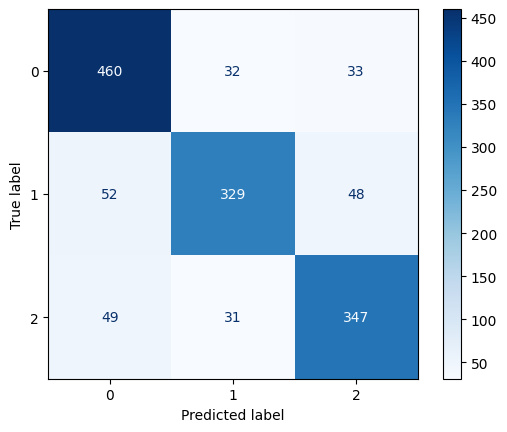

time: 352 ms (started: 2024-06-20 21:19:50 +00:00)


In [143]:
classes = np.unique(true_labels)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')

**{'positive': 0,'neutral': 1, 'negative': 2}**

In [187]:
from sklearn.metrics import classification_report


predictions = df_to_predict['prediction']
true_labels = df_to_predict['true_labels']

class_names = ['positive', 'neutral', 'negative']
report = classification_report(true_labels, predictions, target_names=class_names)

print(report)

              precision    recall  f1-score   support

    positive       0.51      0.71      0.59       148
     neutral       0.14      0.28      0.19        47
    negative       0.85      0.55      0.67       291

    accuracy                           0.57       486
   macro avg       0.50      0.51      0.48       486
weighted avg       0.68      0.57      0.60       486

time: 16.9 ms (started: 2024-06-20 22:51:02 +00:00)
